In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPProcessor, CLIPModel
from tqdm.auto import tqdm
# from PIL import Image
import numpy as np
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
import joblib
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define classes
classes = ["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger"]

In [4]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Load model and pre-processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [6]:
TRAIN_IMG_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "train_set", "train_set", "images")
TRAIN_LABELS_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "train_set", "train_set", "annotations")
VAL_IMG_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "val_set", "val_set", "images")
VAL_LABELS_PATH =  os.path.join(os.getcwd(), "..", "..", "AffectNet", "val_set", "val_set", "annotations")

In [7]:
# os.listdir(TRAIN_LABELS_PATH)

In [8]:
class CustomAffectNetDataset(Dataset):
    def __init__(self, annotations_dir, img_dir, transform=None, target_transform=None):
        # store the image files in sorted order
        self.img_dir = img_dir
        self.label_dir = annotations_dir
        self.img_files = sorted(os.listdir(img_dir))
        # self.img_label_files = sorted([file for file in os.listdir(annotations_dir) if 'exp' in file])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = read_image(img_path)
        label_path = os.path.join(self.label_dir, f"{self.img_files[idx].split('.')[0]}_exp.npy")
        label = int(np.load(label_path))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [9]:
training_data = CustomAffectNetDataset(TRAIN_LABELS_PATH, TRAIN_IMG_PATH)

In [10]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [11]:
# zs_preds = []
embeddings = torch.Tensor([])
labels = []
# deepface_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
# ["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger"]
for img, label in tqdm(train_dataloader):
    # Ignore contempt since deepface ignores it
    label_to_ignore = 7
    relevance_mask = label != label_to_ignore
    img = img[relevance_mask]
    label = label[relevance_mask]
    pil_images = [to_pil_image(i) for i in img]
    label = label.to(device)
    inputs = processor(images=pil_images, return_tensors="pt").to(device)
    # # Use only the image encoder to get image features
    image_features = model.get_image_features(**inputs).to(device)
    labels += label.tolist()
    embeddings = torch.cat((embeddings, image_features.detach().cpu()))

  0%|          | 0/17979 [00:00<?, ?it/s]

C:\Users\Debadyuti\.conda\envs\dissertation-env\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [12]:
# with open("tmp_train_zs_preds.npy", "wb") as f:
#     np.save(f, np.array(zs_preds))
with open("tmp_train_labels.npy", "wb") as f:
    np.save(f, np.array(labels))
with open("tmp_train_embeddings.npy", "wb") as f:
    np.save(f, np.array(embeddings))

In [13]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings)

C:\Users\Debadyuti\AppData\Roaming\Python\Python310\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [14]:
X_embedded.shape

(283901, 2)

In [15]:
from matplotlib import pyplot as plt

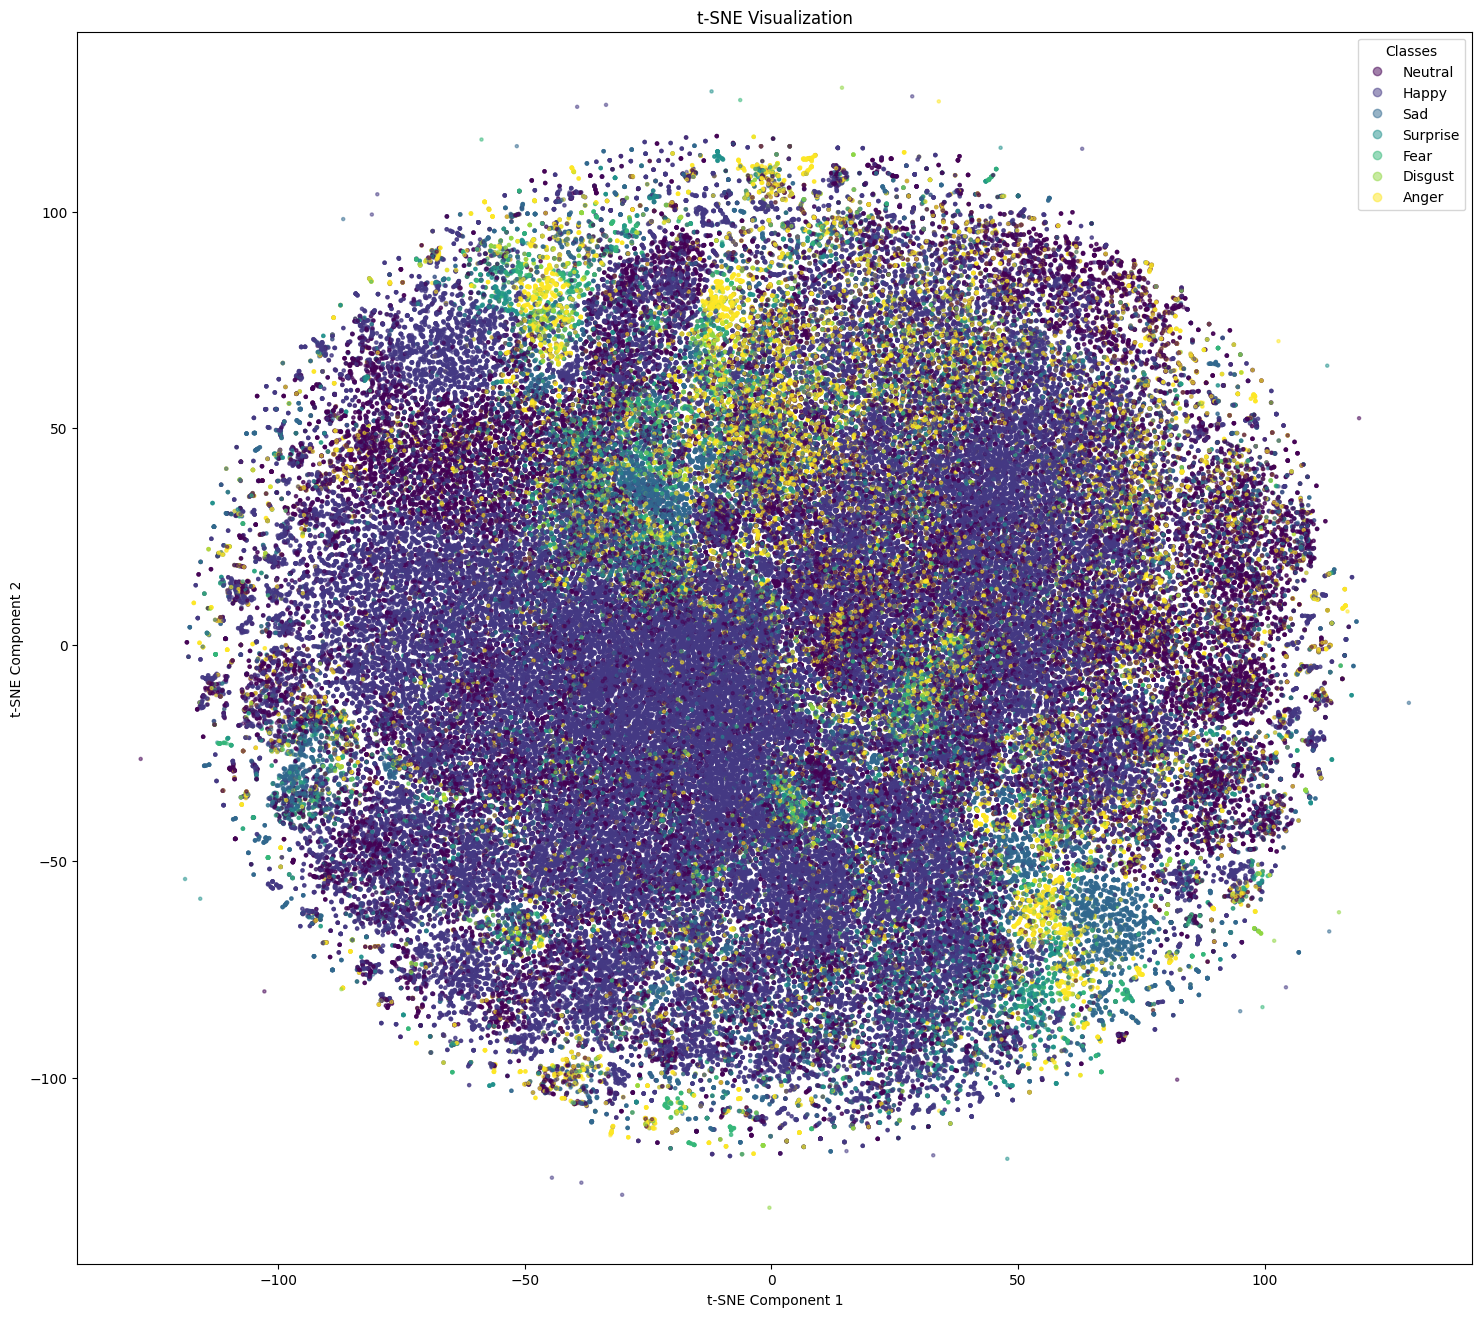

In [16]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, lat_labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in lat_labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")

# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.show()

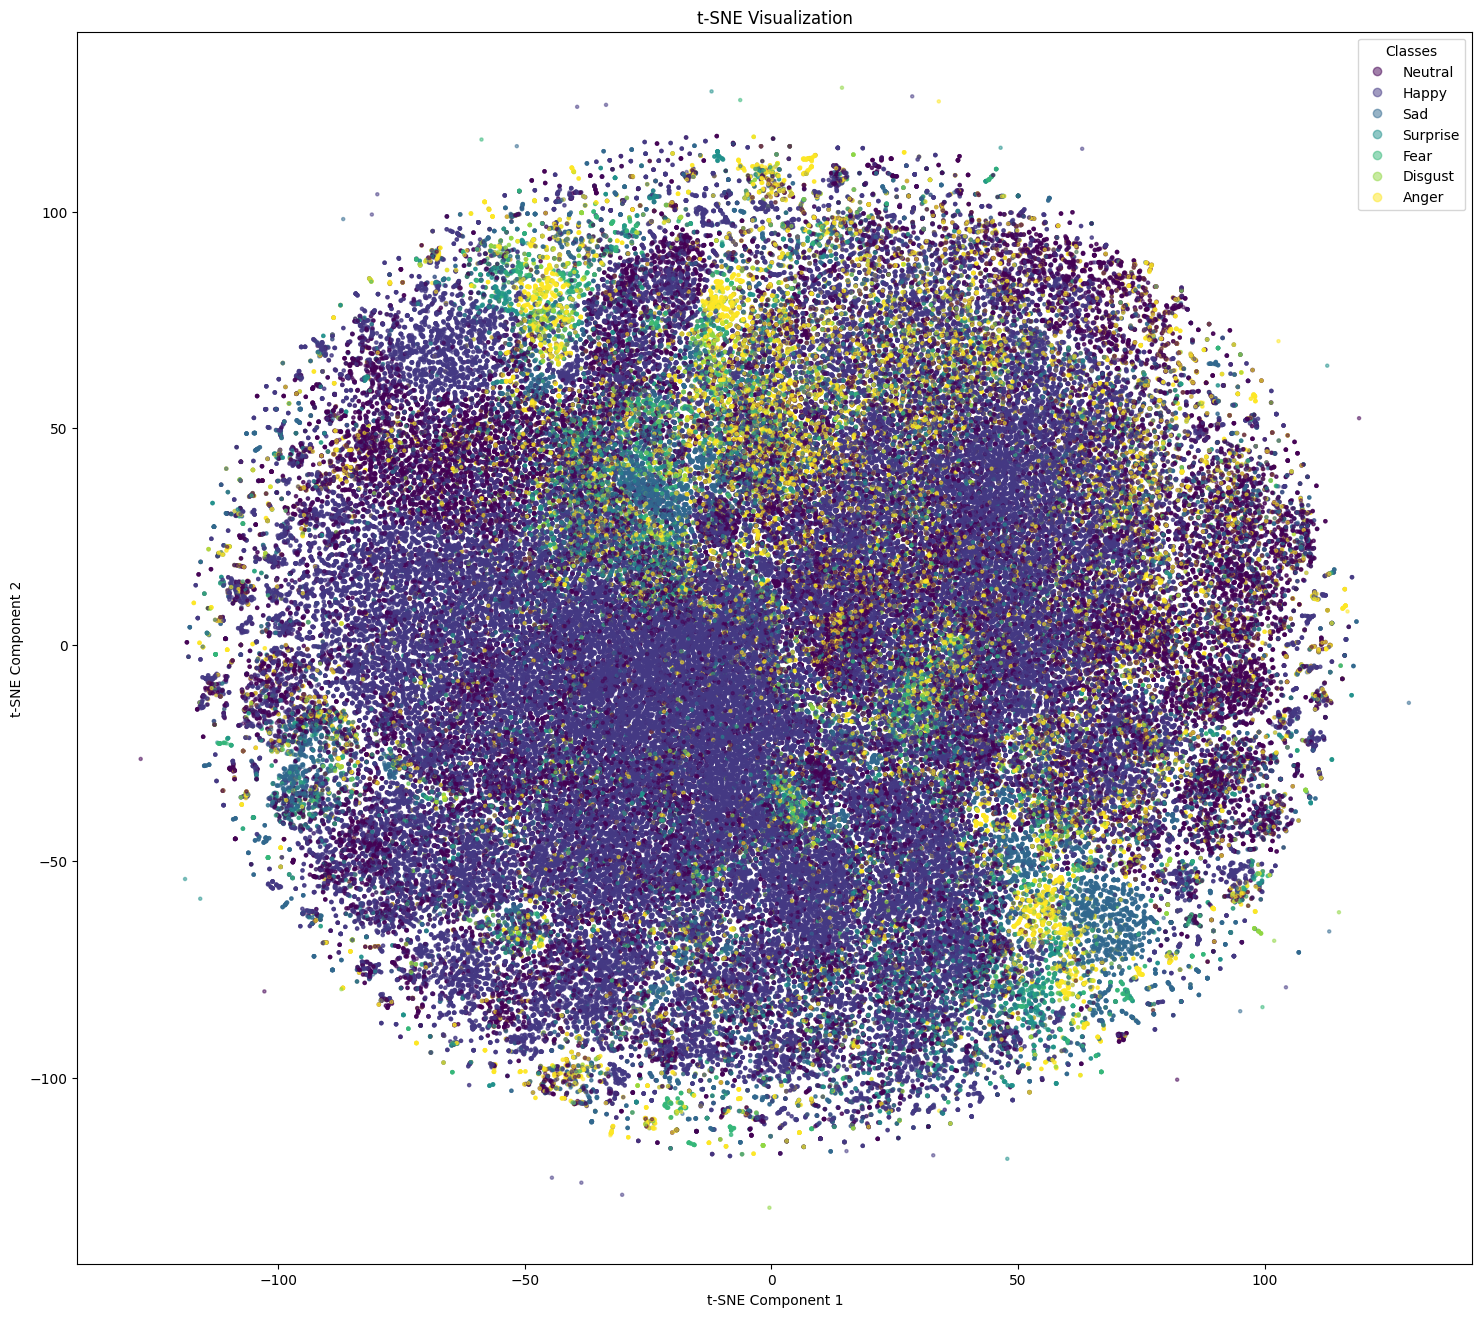

In [17]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', s=5, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, lat_labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in lat_labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")

# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig("training_tsne.png")

In [18]:
validation_data = CustomAffectNetDataset(VAL_LABELS_PATH, VAL_IMG_PATH)

In [19]:
val_dataloader = DataLoader(validation_data, batch_size=16, shuffle=True)

In [20]:
# zs_preds = []
embeddings = torch.Tensor([])
labels = []
# deepface_labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
# ["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Anger"]
for img, label in tqdm(val_dataloader):
    # Ignore contempt since deepface ignores it
    label_to_ignore = 7
    relevance_mask = label != label_to_ignore
    img = img[relevance_mask]
    label = label[relevance_mask]
    pil_images = [to_pil_image(i) for i in img]
    label = label.to(device)
    inputs = processor(images=pil_images, return_tensors="pt").to(device)
    # Use only the image encoder to get image features
    image_features = model.get_image_features(**inputs).to(device)
    labels += label.tolist()
    embeddings = torch.cat((embeddings, image_features.detach().cpu()))

  0%|          | 0/250 [00:00<?, ?it/s]

In [21]:
with open("tmp_val_labels.npy", "wb") as f:
    np.save(f, np.array(labels))
with open("tmp_val_embeddings.npy", "wb") as f:
    np.save(f, np.array(embeddings))

In [22]:
X_val_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings)

In [23]:
X_val_embedded.shape

(3500, 2)

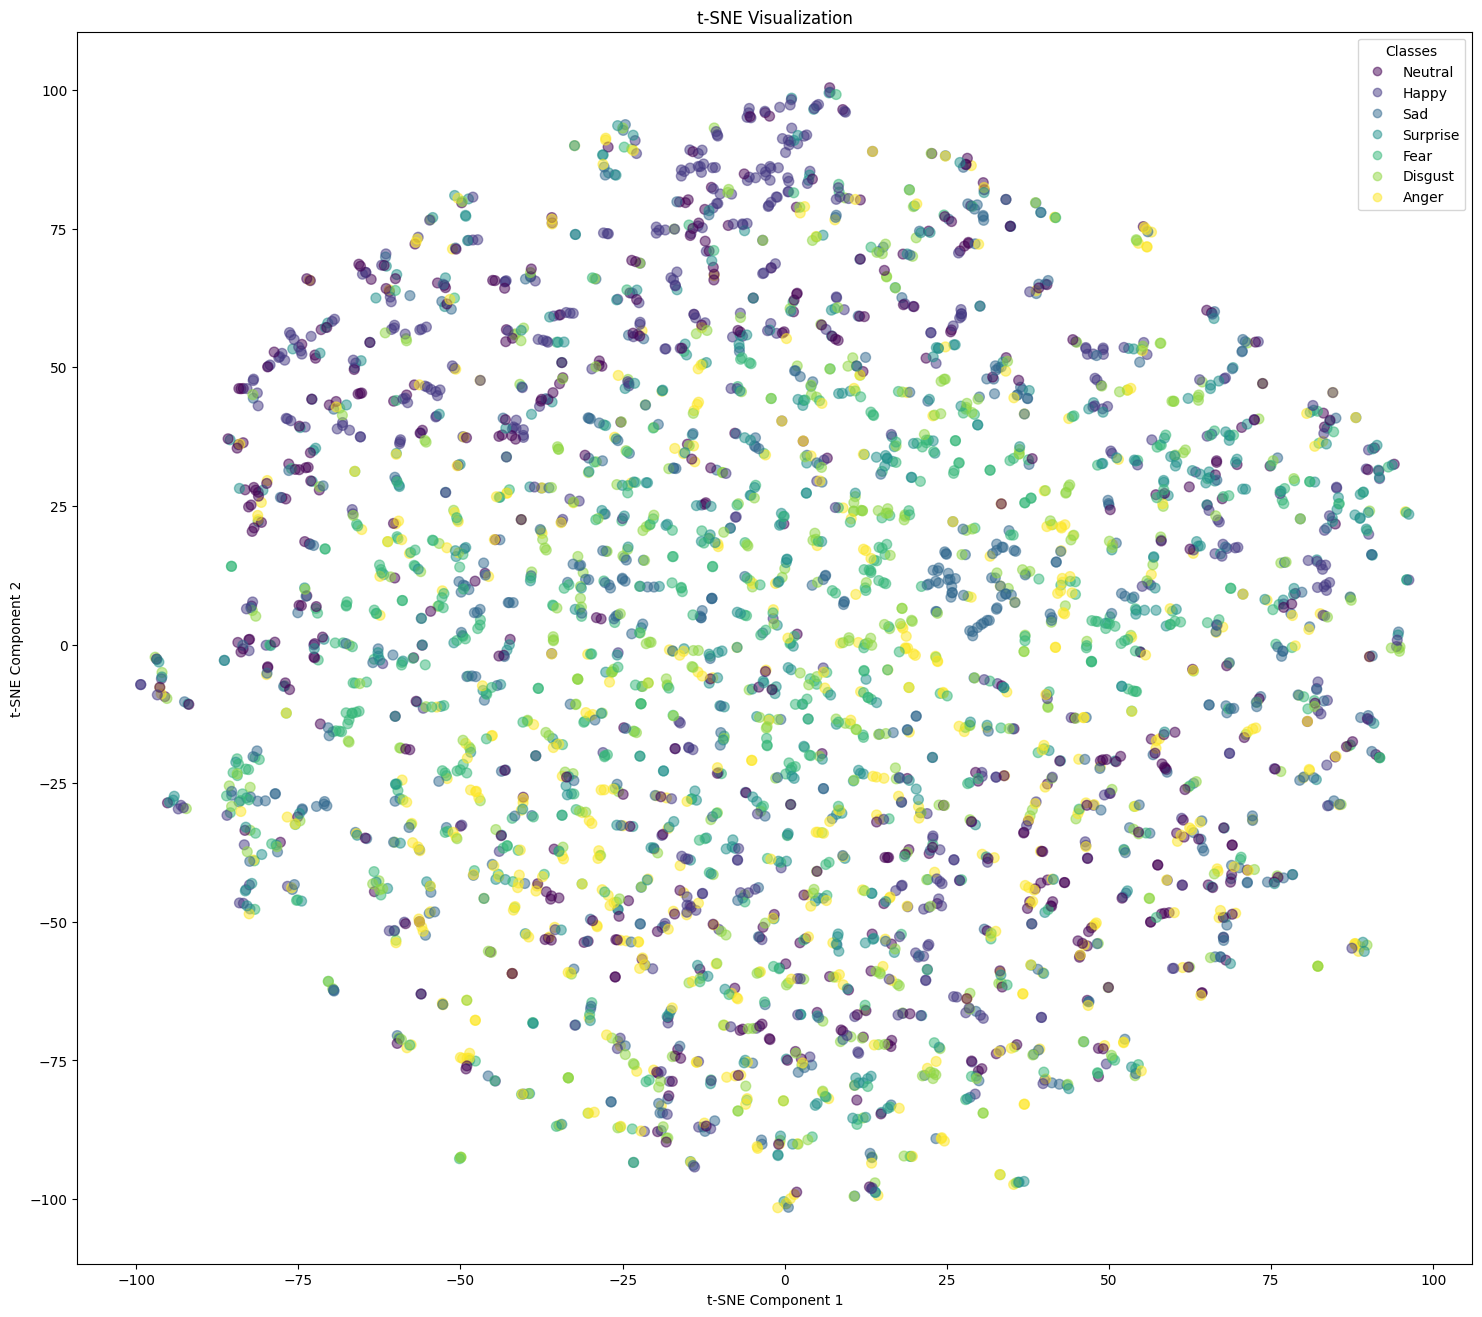

In [24]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_val_embedded[:, 0], X_val_embedded[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, lat_labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in lat_labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")

# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.show()

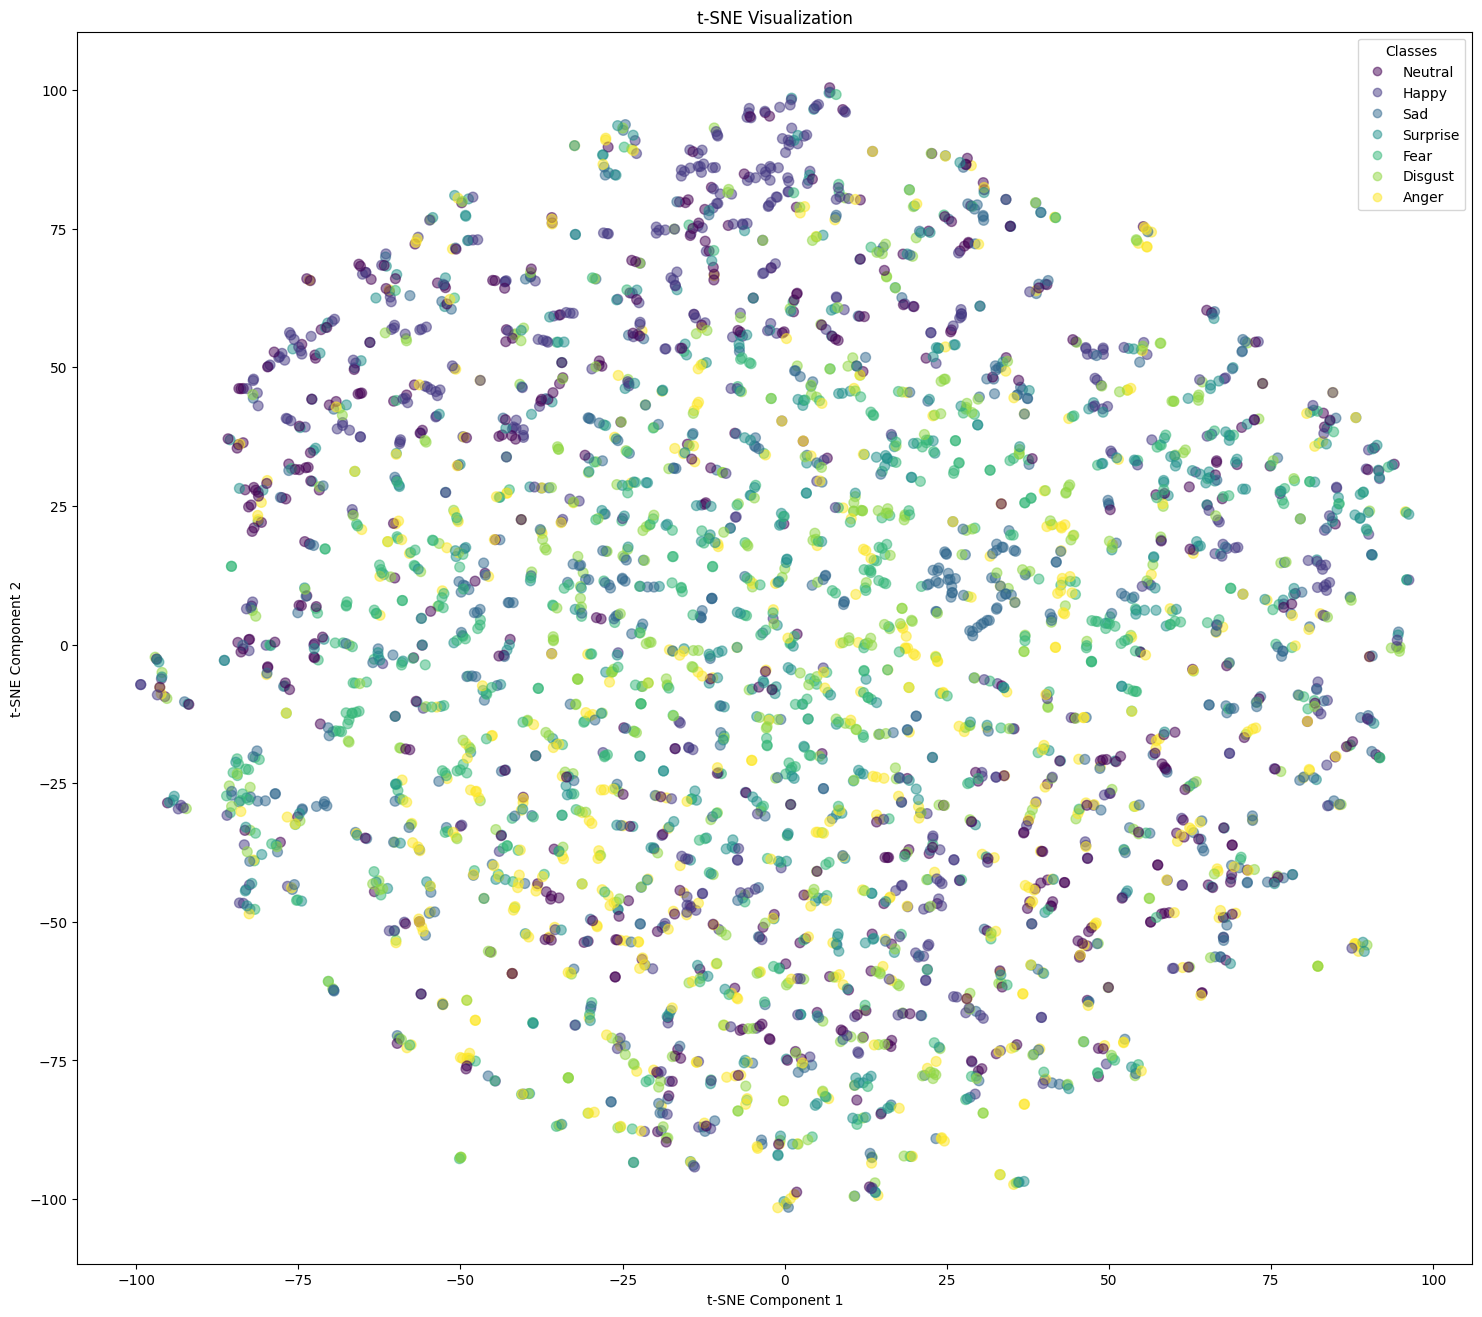

In [25]:
# Create a scatter plot
plt.figure(figsize=(18, 16))
scatter = plt.scatter(X_val_embedded[:, 0], X_val_embedded[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)

# Use the unique labels and their corresponding colors
handles, lat_labels = scatter.legend_elements(prop="colors")
int_labels = [int(label.strip('$\\mathdefault{}')) for label in lat_labels]
legend_labels = [classes[int(label)] for label in int_labels]
plt.legend(handles, legend_labels, title="Classes", loc="best")

# Add titles and labels
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig("validation_tsne.png")